In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import losses
from keras import initializers

import os
import numpy as np
import sys
from tqdm import tqdm_notebook
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model,Sequential
from keras.layers import Input,LeakyReLU,RepeatVector,Reshape,Activation,Dropout,BatchNormalization,Add,Dense,Flatten
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
import random
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.transform import resize
from skimage.morphology import label

C:\Users\roberto\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
path = 'D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/'

In [4]:
TGS_train = pd.read_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/ETL/TGS_train_cluster.csv",sep=';',engine='python')
TGS_test  = pd.read_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/ETL/TGS_test_cluster.csv",sep=';',engine='python')

In [5]:
train_ids = TGS_train['nombre'].as_matrix()
test_ids = TGS_test['nombre'].as_matrix()
train_cluster = TGS_train['cluster'].as_matrix()
test_cluster = TGS_test['cluster'].as_matrix()

In [6]:
train_ids.shape

(7171,)

In [7]:
test_ids.shape

(18000,)

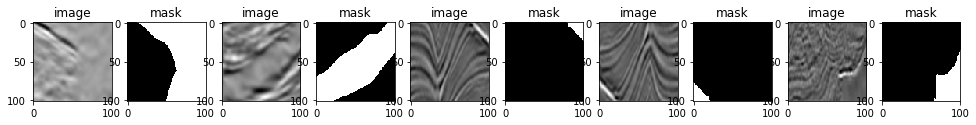

In [8]:
ids= train_ids[355:360]
plt.figure(figsize=(20,10))

for j, img_name in enumerate(ids):
    q = j+1
    img = load_img(path+'train_modif/images/' + img_name)
    img_mask = load_img(path+'train_modif/masks/' + img_name)
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.title('image')
    plt.imshow(img,)
    
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.title('mask')
    plt.imshow(img_mask)
plt.show()

In [9]:
#train_ids = next(os.walk(path+"train_modif/images/"))[2]
#test_ids = next(os.walk(path+"test/images"))[2]

In [10]:
df_depths = pd.read_csv("D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/depths.csv",sep=',',engine='python')
df_depths.head()

,id,z
0,4ac19fb269,306
1,1825fadf99,157
2,f59821d067,305
3,5b435fad9d,503
4,e340e7bfca,783


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B972A99C88>]],
      dtype=object)

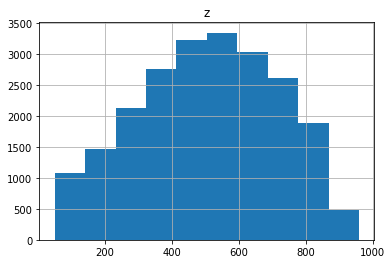

In [11]:
df_depths.hist()

In [12]:
id_train = []
for i in range(len(train_ids)):
    id_train = id_train + [(train_ids[i].split("-")[0])]
    
id_train[0:5]

['000e218f21', '000e218f21', '003c477d7c', '003c477d7c', '00441f1cf2']

In [13]:
#from keras.utils import to_categorical
#train_cluster_one = to_categorical(train_cluster, num_classes=None)
#train_cluster_one.shape

In [14]:
data_train = pd.DataFrame(id_train,columns=["id"])
data_train["nombre"] = train_ids
data_train["cluster"] = train_cluster
#data_train["cluster_1"] = train_cluster_one[:,1]
#data_train["cluster_2"] = train_cluster_one[:,2]
#data_train["cluster_3"] = train_cluster_one[:,3]
#data_train["cluster_4"] = train_cluster_one[:,4]
#data_train["cluster_5"] = train_cluster_one[:,5]
#data_train["cluster_6"] = train_cluster_one[:,6]

In [15]:
data_train.head()

,id,nombre,cluster
0,000e218f21,000e218f21-1.png,4
1,000e218f21,000e218f21-2.png,4
2,003c477d7c,003c477d7c-1.png,1
3,003c477d7c,003c477d7c-2.png,1
4,00441f1cf2,00441f1cf2-1.png,4


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B97259A630>]],
      dtype=object)

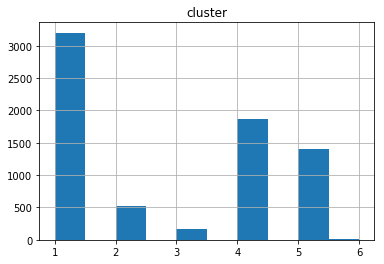

In [16]:
data_train.hist()

In [17]:
data_TGS = data_train.join(df_depths.set_index('id'), on='id', how='left')

In [18]:
data_TGS.head()

,id,nombre,cluster,z
0,000e218f21,000e218f21-1.png,4,841
1,000e218f21,000e218f21-2.png,4,841
2,003c477d7c,003c477d7c-1.png,1,673
3,003c477d7c,003c477d7c-2.png,1,673
4,00441f1cf2,00441f1cf2-1.png,4,330


In [19]:
im_width = 128
im_height = 128
im_chan = 1
n_features = 3

In [20]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
       
    img = load_img(path+'train_modif/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path+'train_modif/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


HBox(children=(IntProgress(value=0, max=7171), HTML(value='')))


Done!


In [21]:
X_train = X_train / 255

In [22]:
X_train.shape

(7171, 128, 128, 1)

In [23]:
X_feat =  data_TGS.iloc[0:,3:4]

In [24]:
scaler = StandardScaler().fit(X_feat)
X_feat = scaler.transform(X_feat)

In [25]:
model = load_model('model_current_best_TGS_binary_v1.h5')
model.load_weights('weights_current_best_TGS_binary_v1.h5')

In [26]:
Y_train_pred = np.round(model.predict({'img': X_train, 'feat': X_feat}))

In [27]:
data_TGS["y_pred"] = Y_train_pred

In [28]:
data_TGS.head()

,id,nombre,cluster,z,y_pred
0,000e218f21,000e218f21-1.png,4,841,0.0
1,000e218f21,000e218f21-2.png,4,841,0.0
2,003c477d7c,003c477d7c-1.png,1,673,0.0
3,003c477d7c,003c477d7c-2.png,1,673,0.0
4,00441f1cf2,00441f1cf2-1.png,4,330,0.0


In [29]:
X_feat_img =  data_TGS.iloc[0:,2:5]

In [30]:
scaler = StandardScaler().fit(X_feat_img)
X_feat_img = scaler.transform(X_feat_img)

In [31]:
X_feat_img.shape

(7171, 3)

4215


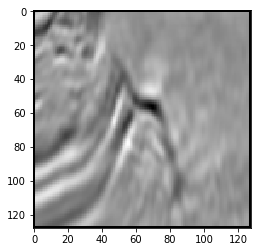

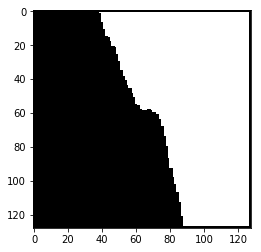

In [32]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
print(ix)
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [33]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

In [34]:
# Build model
def build_model(input_layer, start_neurons, DropoutRatio = 0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)

    # 50 -> 25
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)

    # 25 -> 12
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)

    # 12 -> 6
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
    
    # Middle   
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)
    
    f_repeat = RepeatVector(6*6)(input_features)
    f_conv = Reshape((6, 6, n_features))(f_repeat)
    p4_feat = concatenate([convm, f_conv], -1)
       
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(p4_feat)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    # 12 -> 25
    #deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="valid")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Dropout(DropoutRatio)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    # 50 -> 101
    #deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="valid")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Dropout(DropoutRatio)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    #uconv1 = Dropout(DropoutRatio/2)(uconv1)
    #output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    output_layer_noActi = Conv2D(1, (1,1), padding="same", activation=None)(uconv1)
    output_layer =  Activation('sigmoid')(output_layer_noActi)
    
    return output_layer


In [35]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) > 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) >= 1 and np.count_nonzero(p) == 0:
#             metric.append(0)
#             continue
#         if np.count_nonzero(t) == 0 and np.count_nonzero(p) == 0:
#             metric.append(1)
#             continue
        
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))

    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [36]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


In [37]:
im_width = 101
im_height = 101
im_chan = 1
n_features = 3

In [38]:
# Get and resize train images and masks
x_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
       
    img = load_img(path+'train_modif/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (101, 101, 1), mode='constant', preserve_range=True)
    x_train[n] = x
    mask = img_to_array(load_img(path+'train_modif/masks/' + id_))[:,:,1]
    y_train[n] = resize(mask, (101, 101, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


HBox(children=(IntProgress(value=0, max=7171), HTML(value='')))


Done!


In [39]:
x_train = x_train / 255

In [50]:
# model
 
inputs = Input((101,101,1),name='img')
input_features = Input((n_features, ), name='feat')

input_layer = inputs
outputs = build_model(input_layer, 16, 0.15)

model = Model(inputs=[inputs, input_features], outputs=[outputs])

c = optimizers.adam(lr = 0.01)
model.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 101, 101, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 101, 101, 16) 64          conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 101, 101, 16) 0           batch_normalization_46[0][0]     
__________________________________________________________________________________________________
conv2d_48 

__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 6, 6, 256)    295168      dropout_12[0][0]                 
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 6, 6, 256)    1024        conv2d_67[0][0]                  
__________________________________________________________________________________________________
activation_67 (Activation)      (None, 6, 6, 256)    0           batch_normalization_66[0][0]     
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 6, 6, 256)    590080      activation_67[0][0]              
__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, 6, 6, 256)    1024        conv2d_68[0][0]                  
__________

activation_85 (Activation)      (None, 50, 50, 32)   0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 50, 50, 32)   9248        activation_85[0][0]              
__________________________________________________________________________________________________
add_34 (Add)                    (None, 50, 50, 32)   0           conv2d_86[0][0]                  
                                                                 add_33[0][0]                     
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 50, 50, 32)   128         add_34[0][0]                     
__________________________________________________________________________________________________
activation_86 (Activation)      (None, 50, 50, 32)   0           batch_normalization_85[0][0]     
__________

In [43]:
model_checkpoint = ModelCheckpoint('model_current_best_TGS_v3.h5',monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 50
batch_size = 32
history = model.fit({'img': x_train, 'feat': X_feat_img}, y_train,
                    validation_split=0.15, 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr], 
                    verbose=1)

Train on 6095 samples, validate on 1076 samples
Epoch 1/50
5184/6095 [========================>.....] - ETA: 52:44 - loss: 0.5815 - my_iou_metric: 0.50 - ETA: 45:16 - loss: 0.4911 - my_iou_metric: 0.56 - ETA: 42:49 - loss: 0.4666 - my_iou_metric: 0.54 - ETA: 41:25 - loss: 0.4548 - my_iou_metric: 0.55 - ETA: 40:32 - loss: 0.4485 - my_iou_metric: 0.55 - ETA: 39:55 - loss: 0.4434 - my_iou_metric: 0.55 - ETA: 39:25 - loss: 0.4335 - my_iou_metric: 0.58 - ETA: 39:03 - loss: 0.4134 - my_iou_metric: 0.60 - ETA: 38:40 - loss: 0.4065 - my_iou_metric: 0.59 - ETA: 38:21 - loss: 0.4082 - my_iou_metric: 0.59 - ETA: 37:54 - loss: 0.4038 - my_iou_metric: 0.60 - ETA: 37:30 - loss: 0.3992 - my_iou_metric: 0.59 - ETA: 37:12 - loss: 0.3967 - my_iou_metric: 0.59 - ETA: 36:51 - loss: 0.3924 - my_iou_metric: 0.58 - ETA: 36:34 - loss: 0.4105 - my_iou_metric: 0.57 - ETA: 36:19 - loss: 0.4108 - my_iou_metric: 0.58 - ETA: 36:05 - loss: 0.4075 - my_iou_metric: 0.58 - ETA: 35:51 - loss: 0.3991 - my_iou_metric: 0.5

5216/6095 [========================>.....] - ETA: 36:59 - loss: 0.2523 - my_iou_metric: 0.66 - ETA: 36:55 - loss: 0.1962 - my_iou_metric: 0.72 - ETA: 36:41 - loss: 0.2197 - my_iou_metric: 0.68 - ETA: 36:29 - loss: 0.2558 - my_iou_metric: 0.66 - ETA: 36:16 - loss: 0.2413 - my_iou_metric: 0.68 - ETA: 36:03 - loss: 0.2368 - my_iou_metric: 0.66 - ETA: 35:52 - loss: 0.2354 - my_iou_metric: 0.67 - ETA: 35:41 - loss: 0.2343 - my_iou_metric: 0.67 - ETA: 35:29 - loss: 0.2451 - my_iou_metric: 0.66 - ETA: 35:18 - loss: 0.2510 - my_iou_metric: 0.65 - ETA: 35:06 - loss: 0.2425 - my_iou_metric: 0.66 - ETA: 34:56 - loss: 0.2534 - my_iou_metric: 0.65 - ETA: 34:44 - loss: 0.2606 - my_iou_metric: 0.65 - ETA: 34:32 - loss: 0.2575 - my_iou_metric: 0.64 - ETA: 34:20 - loss: 0.2624 - my_iou_metric: 0.64 - ETA: 34:09 - loss: 0.2675 - my_iou_metric: 0.64 - ETA: 33:58 - loss: 0.2635 - my_iou_metric: 0.63 - ETA: 33:46 - loss: 0.2590 - my_iou_metric: 0.63 - ETA: 33:34 - loss: 0.2645 - my_iou_metric: 0.64 - ETA: 

6095/6095 [==============================] - ETA: 5:12 - loss: 0.2585 - my_iou_metric: 0.632 - ETA: 5:00 - loss: 0.2591 - my_iou_metric: 0.632 - ETA: 4:48 - loss: 0.2602 - my_iou_metric: 0.631 - ETA: 4:36 - loss: 0.2603 - my_iou_metric: 0.631 - ETA: 4:25 - loss: 0.2596 - my_iou_metric: 0.632 - ETA: 4:13 - loss: 0.2589 - my_iou_metric: 0.632 - ETA: 4:01 - loss: 0.2588 - my_iou_metric: 0.632 - ETA: 3:49 - loss: 0.2582 - my_iou_metric: 0.632 - ETA: 3:37 - loss: 0.2581 - my_iou_metric: 0.633 - ETA: 3:26 - loss: 0.2582 - my_iou_metric: 0.633 - ETA: 3:14 - loss: 0.2575 - my_iou_metric: 0.633 - ETA: 3:02 - loss: 0.2581 - my_iou_metric: 0.632 - ETA: 2:50 - loss: 0.2587 - my_iou_metric: 0.631 - ETA: 2:38 - loss: 0.2584 - my_iou_metric: 0.632 - ETA: 2:27 - loss: 0.2590 - my_iou_metric: 0.631 - ETA: 2:15 - loss: 0.2589 - my_iou_metric: 0.631 - ETA: 2:03 - loss: 0.2591 - my_iou_metric: 0.631 - ETA: 1:51 - loss: 0.2586 - my_iou_metric: 0.631 - ETA: 1:39 - loss: 0.2595 - my_iou_metric: 0.630 - ETA: 

5216/6095 [========================>.....] - ETA: 38:29 - loss: 0.2054 - my_iou_metric: 0.67 - ETA: 38:29 - loss: 0.2472 - my_iou_metric: 0.61 - ETA: 38:10 - loss: 0.2768 - my_iou_metric: 0.62 - ETA: 37:56 - loss: 0.2455 - my_iou_metric: 0.64 - ETA: 37:39 - loss: 0.2368 - my_iou_metric: 0.64 - ETA: 37:21 - loss: 0.2194 - my_iou_metric: 0.63 - ETA: 37:33 - loss: 0.2113 - my_iou_metric: 0.63 - ETA: 37:37 - loss: 0.2163 - my_iou_metric: 0.63 - ETA: 37:38 - loss: 0.2138 - my_iou_metric: 0.63 - ETA: 37:34 - loss: 0.2036 - my_iou_metric: 0.65 - ETA: 37:25 - loss: 0.2048 - my_iou_metric: 0.65 - ETA: 37:12 - loss: 0.2081 - my_iou_metric: 0.64 - ETA: 36:58 - loss: 0.2008 - my_iou_metric: 0.64 - ETA: 36:45 - loss: 0.2127 - my_iou_metric: 0.64 - ETA: 36:32 - loss: 0.2077 - my_iou_metric: 0.65 - ETA: 36:17 - loss: 0.2048 - my_iou_metric: 0.65 - ETA: 36:07 - loss: 0.2069 - my_iou_metric: 0.66 - ETA: 36:01 - loss: 0.2223 - my_iou_metric: 0.65 - ETA: 35:45 - loss: 0.2223 - my_iou_metric: 0.65 - ETA: 

6095/6095 [==============================] - ETA: 5:24 - loss: 0.2319 - my_iou_metric: 0.651 - ETA: 5:11 - loss: 0.2318 - my_iou_metric: 0.652 - ETA: 4:59 - loss: 0.2316 - my_iou_metric: 0.652 - ETA: 4:47 - loss: 0.2310 - my_iou_metric: 0.652 - ETA: 4:35 - loss: 0.2307 - my_iou_metric: 0.653 - ETA: 4:22 - loss: 0.2308 - my_iou_metric: 0.653 - ETA: 4:10 - loss: 0.2306 - my_iou_metric: 0.654 - ETA: 3:58 - loss: 0.2307 - my_iou_metric: 0.653 - ETA: 3:46 - loss: 0.2307 - my_iou_metric: 0.653 - ETA: 3:33 - loss: 0.2311 - my_iou_metric: 0.653 - ETA: 3:21 - loss: 0.2304 - my_iou_metric: 0.653 - ETA: 3:09 - loss: 0.2302 - my_iou_metric: 0.653 - ETA: 2:57 - loss: 0.2301 - my_iou_metric: 0.653 - ETA: 2:44 - loss: 0.2302 - my_iou_metric: 0.653 - ETA: 2:32 - loss: 0.2314 - my_iou_metric: 0.653 - ETA: 2:20 - loss: 0.2312 - my_iou_metric: 0.653 - ETA: 2:08 - loss: 0.2308 - my_iou_metric: 0.654 - ETA: 1:55 - loss: 0.2311 - my_iou_metric: 0.654 - ETA: 1:43 - loss: 0.2311 - my_iou_metric: 0.654 - ETA: 

5216/6095 [========================>.....] - ETA: 40:03 - loss: 0.1463 - my_iou_metric: 0.67 - ETA: 39:35 - loss: 0.1635 - my_iou_metric: 0.65 - ETA: 39:18 - loss: 0.1541 - my_iou_metric: 0.68 - ETA: 39:04 - loss: 0.1605 - my_iou_metric: 0.68 - ETA: 38:47 - loss: 0.1687 - my_iou_metric: 0.69 - ETA: 38:34 - loss: 0.1689 - my_iou_metric: 0.69 - ETA: 38:21 - loss: 0.1650 - my_iou_metric: 0.68 - ETA: 38:07 - loss: 0.1601 - my_iou_metric: 0.67 - ETA: 37:53 - loss: 0.1711 - my_iou_metric: 0.68 - ETA: 37:41 - loss: 0.1812 - my_iou_metric: 0.66 - ETA: 37:27 - loss: 0.2051 - my_iou_metric: 0.65 - ETA: 37:15 - loss: 0.2023 - my_iou_metric: 0.65 - ETA: 37:02 - loss: 0.2074 - my_iou_metric: 0.65 - ETA: 36:49 - loss: 0.2081 - my_iou_metric: 0.65 - ETA: 36:37 - loss: 0.2127 - my_iou_metric: 0.66 - ETA: 36:24 - loss: 0.2143 - my_iou_metric: 0.66 - ETA: 36:12 - loss: 0.2155 - my_iou_metric: 0.66 - ETA: 35:59 - loss: 0.2169 - my_iou_metric: 0.65 - ETA: 35:46 - loss: 0.2251 - my_iou_metric: 0.64 - ETA: 

6095/6095 [==============================] - ETA: 5:34 - loss: 0.2257 - my_iou_metric: 0.651 - ETA: 5:21 - loss: 0.2254 - my_iou_metric: 0.650 - ETA: 5:09 - loss: 0.2251 - my_iou_metric: 0.650 - ETA: 4:56 - loss: 0.2251 - my_iou_metric: 0.649 - ETA: 4:43 - loss: 0.2250 - my_iou_metric: 0.649 - ETA: 4:31 - loss: 0.2251 - my_iou_metric: 0.649 - ETA: 4:18 - loss: 0.2250 - my_iou_metric: 0.648 - ETA: 4:05 - loss: 0.2250 - my_iou_metric: 0.648 - ETA: 3:53 - loss: 0.2260 - my_iou_metric: 0.648 - ETA: 3:40 - loss: 0.2262 - my_iou_metric: 0.647 - ETA: 3:27 - loss: 0.2257 - my_iou_metric: 0.648 - ETA: 3:15 - loss: 0.2257 - my_iou_metric: 0.648 - ETA: 3:02 - loss: 0.2254 - my_iou_metric: 0.649 - ETA: 2:50 - loss: 0.2250 - my_iou_metric: 0.649 - ETA: 2:37 - loss: 0.2249 - my_iou_metric: 0.649 - ETA: 2:24 - loss: 0.2249 - my_iou_metric: 0.649 - ETA: 2:12 - loss: 0.2247 - my_iou_metric: 0.649 - ETA: 1:59 - loss: 0.2247 - my_iou_metric: 0.648 - ETA: 1:46 - loss: 0.2250 - my_iou_metric: 0.648 - ETA: 

5216/6095 [========================>.....] - ETA: 38:58 - loss: 0.1539 - my_iou_metric: 0.65 - ETA: 38:41 - loss: 0.1454 - my_iou_metric: 0.66 - ETA: 38:27 - loss: 0.1455 - my_iou_metric: 0.66 - ETA: 38:11 - loss: 0.1749 - my_iou_metric: 0.63 - ETA: 37:57 - loss: 0.1837 - my_iou_metric: 0.64 - ETA: 37:47 - loss: 0.1859 - my_iou_metric: 0.64 - ETA: 37:35 - loss: 0.1785 - my_iou_metric: 0.66 - ETA: 37:24 - loss: 0.1836 - my_iou_metric: 0.65 - ETA: 37:10 - loss: 0.1815 - my_iou_metric: 0.66 - ETA: 36:57 - loss: 0.1816 - my_iou_metric: 0.65 - ETA: 36:45 - loss: 0.1820 - my_iou_metric: 0.66 - ETA: 36:32 - loss: 0.1936 - my_iou_metric: 0.65 - ETA: 36:19 - loss: 0.2062 - my_iou_metric: 0.65 - ETA: 36:09 - loss: 0.2081 - my_iou_metric: 0.65 - ETA: 36:00 - loss: 0.2011 - my_iou_metric: 0.66 - ETA: 35:49 - loss: 0.1959 - my_iou_metric: 0.67 - ETA: 35:36 - loss: 0.1968 - my_iou_metric: 0.66 - ETA: 35:25 - loss: 0.1939 - my_iou_metric: 0.66 - ETA: 35:12 - loss: 0.1892 - my_iou_metric: 0.66 - ETA: 

6095/6095 [==============================] - ETA: 5:21 - loss: 0.2097 - my_iou_metric: 0.657 - ETA: 5:09 - loss: 0.2093 - my_iou_metric: 0.657 - ETA: 4:57 - loss: 0.2086 - my_iou_metric: 0.658 - ETA: 4:45 - loss: 0.2090 - my_iou_metric: 0.658 - ETA: 4:32 - loss: 0.2090 - my_iou_metric: 0.658 - ETA: 4:20 - loss: 0.2090 - my_iou_metric: 0.659 - ETA: 4:08 - loss: 0.2084 - my_iou_metric: 0.659 - ETA: 3:56 - loss: 0.2079 - my_iou_metric: 0.660 - ETA: 3:44 - loss: 0.2081 - my_iou_metric: 0.659 - ETA: 3:32 - loss: 0.2083 - my_iou_metric: 0.660 - ETA: 3:19 - loss: 0.2080 - my_iou_metric: 0.659 - ETA: 3:07 - loss: 0.2079 - my_iou_metric: 0.659 - ETA: 2:55 - loss: 0.2079 - my_iou_metric: 0.659 - ETA: 2:43 - loss: 0.2078 - my_iou_metric: 0.659 - ETA: 2:31 - loss: 0.2071 - my_iou_metric: 0.659 - ETA: 2:19 - loss: 0.2071 - my_iou_metric: 0.659 - ETA: 2:07 - loss: 0.2070 - my_iou_metric: 0.659 - ETA: 1:54 - loss: 0.2071 - my_iou_metric: 0.658 - ETA: 1:42 - loss: 0.2065 - my_iou_metric: 0.658 - ETA: 

5216/6095 [========================>.....] - ETA: 37:09 - loss: 0.2658 - my_iou_metric: 0.63 - ETA: 36:45 - loss: 0.3096 - my_iou_metric: 0.59 - ETA: 36:37 - loss: 0.2866 - my_iou_metric: 0.58 - ETA: 36:23 - loss: 0.2535 - my_iou_metric: 0.59 - ETA: 36:18 - loss: 0.2410 - my_iou_metric: 0.61 - ETA: 36:21 - loss: 0.2287 - my_iou_metric: 0.62 - ETA: 36:20 - loss: 0.2183 - my_iou_metric: 0.63 - ETA: 36:16 - loss: 0.2224 - my_iou_metric: 0.63 - ETA: 36:10 - loss: 0.2217 - my_iou_metric: 0.62 - ETA: 36:04 - loss: 0.2286 - my_iou_metric: 0.61 - ETA: 35:49 - loss: 0.2245 - my_iou_metric: 0.61 - ETA: 35:36 - loss: 0.2196 - my_iou_metric: 0.61 - ETA: 35:21 - loss: 0.2201 - my_iou_metric: 0.61 - ETA: 35:06 - loss: 0.2262 - my_iou_metric: 0.60 - ETA: 34:51 - loss: 0.2202 - my_iou_metric: 0.61 - ETA: 34:36 - loss: 0.2168 - my_iou_metric: 0.61 - ETA: 34:22 - loss: 0.2250 - my_iou_metric: 0.61 - ETA: 34:09 - loss: 0.2207 - my_iou_metric: 0.61 - ETA: 33:55 - loss: 0.2167 - my_iou_metric: 0.61 - ETA: 

6095/6095 [==============================] - ETA: 5:10 - loss: 0.1929 - my_iou_metric: 0.671 - ETA: 4:58 - loss: 0.1933 - my_iou_metric: 0.671 - ETA: 4:47 - loss: 0.1930 - my_iou_metric: 0.671 - ETA: 4:35 - loss: 0.1925 - my_iou_metric: 0.671 - ETA: 4:23 - loss: 0.1926 - my_iou_metric: 0.671 - ETA: 4:11 - loss: 0.1921 - my_iou_metric: 0.671 - ETA: 4:00 - loss: 0.1921 - my_iou_metric: 0.670 - ETA: 3:48 - loss: 0.1928 - my_iou_metric: 0.670 - ETA: 3:36 - loss: 0.1924 - my_iou_metric: 0.670 - ETA: 3:24 - loss: 0.1923 - my_iou_metric: 0.670 - ETA: 3:13 - loss: 0.1932 - my_iou_metric: 0.670 - ETA: 3:01 - loss: 0.1931 - my_iou_metric: 0.670 - ETA: 2:49 - loss: 0.1929 - my_iou_metric: 0.670 - ETA: 2:38 - loss: 0.1926 - my_iou_metric: 0.670 - ETA: 2:26 - loss: 0.1929 - my_iou_metric: 0.670 - ETA: 2:14 - loss: 0.1933 - my_iou_metric: 0.670 - ETA: 2:02 - loss: 0.1934 - my_iou_metric: 0.670 - ETA: 1:51 - loss: 0.1935 - my_iou_metric: 0.669 - ETA: 1:39 - loss: 0.1933 - my_iou_metric: 0.670 - ETA: 

5216/6095 [========================>.....] - ETA: 37:07 - loss: 0.1814 - my_iou_metric: 0.52 - ETA: 36:51 - loss: 0.1495 - my_iou_metric: 0.62 - ETA: 36:36 - loss: 0.2125 - my_iou_metric: 0.65 - ETA: 36:21 - loss: 0.1981 - my_iou_metric: 0.67 - ETA: 36:09 - loss: 0.1927 - my_iou_metric: 0.69 - ETA: 36:02 - loss: 0.2102 - my_iou_metric: 0.67 - ETA: 35:50 - loss: 0.2110 - my_iou_metric: 0.66 - ETA: 35:37 - loss: 0.2059 - my_iou_metric: 0.67 - ETA: 35:25 - loss: 0.2177 - my_iou_metric: 0.67 - ETA: 35:13 - loss: 0.2187 - my_iou_metric: 0.66 - ETA: 35:02 - loss: 0.2184 - my_iou_metric: 0.65 - ETA: 34:50 - loss: 0.2228 - my_iou_metric: 0.65 - ETA: 34:37 - loss: 0.2259 - my_iou_metric: 0.65 - ETA: 34:25 - loss: 0.2274 - my_iou_metric: 0.65 - ETA: 34:13 - loss: 0.2210 - my_iou_metric: 0.66 - ETA: 34:03 - loss: 0.2167 - my_iou_metric: 0.66 - ETA: 33:51 - loss: 0.2141 - my_iou_metric: 0.66 - ETA: 33:39 - loss: 0.2110 - my_iou_metric: 0.66 - ETA: 33:27 - loss: 0.2135 - my_iou_metric: 0.66 - ETA: 

6095/6095 [==============================] - ETA: 5:10 - loss: 0.1858 - my_iou_metric: 0.677 - ETA: 4:58 - loss: 0.1861 - my_iou_metric: 0.677 - ETA: 4:46 - loss: 0.1859 - my_iou_metric: 0.676 - ETA: 4:34 - loss: 0.1858 - my_iou_metric: 0.676 - ETA: 4:23 - loss: 0.1861 - my_iou_metric: 0.675 - ETA: 4:11 - loss: 0.1861 - my_iou_metric: 0.675 - ETA: 3:59 - loss: 0.1857 - my_iou_metric: 0.676 - ETA: 3:48 - loss: 0.1866 - my_iou_metric: 0.675 - ETA: 3:36 - loss: 0.1864 - my_iou_metric: 0.675 - ETA: 3:24 - loss: 0.1869 - my_iou_metric: 0.675 - ETA: 3:12 - loss: 0.1868 - my_iou_metric: 0.675 - ETA: 3:01 - loss: 0.1865 - my_iou_metric: 0.675 - ETA: 2:49 - loss: 0.1867 - my_iou_metric: 0.675 - ETA: 2:37 - loss: 0.1867 - my_iou_metric: 0.674 - ETA: 2:26 - loss: 0.1867 - my_iou_metric: 0.674 - ETA: 2:14 - loss: 0.1871 - my_iou_metric: 0.674 - ETA: 2:02 - loss: 0.1867 - my_iou_metric: 0.674 - ETA: 1:50 - loss: 0.1867 - my_iou_metric: 0.674 - ETA: 1:39 - loss: 0.1867 - my_iou_metric: 0.674 - ETA: 

5216/6095 [========================>.....] - ETA: 37:02 - loss: 0.2382 - my_iou_metric: 0.65 - ETA: 36:45 - loss: 0.1823 - my_iou_metric: 0.68 - ETA: 36:35 - loss: 0.1903 - my_iou_metric: 0.67 - ETA: 36:28 - loss: 0.1971 - my_iou_metric: 0.70 - ETA: 36:13 - loss: 0.1823 - my_iou_metric: 0.66 - ETA: 36:01 - loss: 0.1722 - my_iou_metric: 0.67 - ETA: 35:50 - loss: 0.1639 - my_iou_metric: 0.67 - ETA: 35:38 - loss: 0.1595 - my_iou_metric: 0.67 - ETA: 35:27 - loss: 0.1505 - my_iou_metric: 0.68 - ETA: 35:15 - loss: 0.1493 - my_iou_metric: 0.67 - ETA: 35:04 - loss: 0.1540 - my_iou_metric: 0.67 - ETA: 34:52 - loss: 0.1584 - my_iou_metric: 0.68 - ETA: 34:40 - loss: 0.1523 - my_iou_metric: 0.68 - ETA: 34:30 - loss: 0.1605 - my_iou_metric: 0.68 - ETA: 34:19 - loss: 0.1542 - my_iou_metric: 0.69 - ETA: 34:07 - loss: 0.1530 - my_iou_metric: 0.69 - ETA: 33:55 - loss: 0.1571 - my_iou_metric: 0.69 - ETA: 33:43 - loss: 0.1579 - my_iou_metric: 0.69 - ETA: 33:30 - loss: 0.1608 - my_iou_metric: 0.70 - ETA: 

6095/6095 [==============================] - ETA: 5:09 - loss: 0.1780 - my_iou_metric: 0.682 - ETA: 4:58 - loss: 0.1780 - my_iou_metric: 0.682 - ETA: 4:46 - loss: 0.1792 - my_iou_metric: 0.681 - ETA: 4:34 - loss: 0.1797 - my_iou_metric: 0.680 - ETA: 4:23 - loss: 0.1794 - my_iou_metric: 0.680 - ETA: 4:11 - loss: 0.1793 - my_iou_metric: 0.681 - ETA: 3:59 - loss: 0.1791 - my_iou_metric: 0.680 - ETA: 3:48 - loss: 0.1787 - my_iou_metric: 0.680 - ETA: 3:36 - loss: 0.1784 - my_iou_metric: 0.680 - ETA: 3:24 - loss: 0.1783 - my_iou_metric: 0.681 - ETA: 3:12 - loss: 0.1784 - my_iou_metric: 0.680 - ETA: 3:01 - loss: 0.1781 - my_iou_metric: 0.680 - ETA: 2:49 - loss: 0.1776 - my_iou_metric: 0.680 - ETA: 2:37 - loss: 0.1774 - my_iou_metric: 0.681 - ETA: 2:26 - loss: 0.1770 - my_iou_metric: 0.680 - ETA: 2:14 - loss: 0.1768 - my_iou_metric: 0.681 - ETA: 2:02 - loss: 0.1768 - my_iou_metric: 0.681 - ETA: 1:50 - loss: 0.1775 - my_iou_metric: 0.681 - ETA: 1:39 - loss: 0.1772 - my_iou_metric: 0.681 - ETA: 

5216/6095 [========================>.....] - ETA: 37:01 - loss: 0.2275 - my_iou_metric: 0.69 - ETA: 36:51 - loss: 0.2284 - my_iou_metric: 0.66 - ETA: 36:38 - loss: 0.2424 - my_iou_metric: 0.62 - ETA: 36:24 - loss: 0.2163 - my_iou_metric: 0.64 - ETA: 36:11 - loss: 0.2037 - my_iou_metric: 0.65 - ETA: 35:57 - loss: 0.2269 - my_iou_metric: 0.63 - ETA: 35:47 - loss: 0.2090 - my_iou_metric: 0.65 - ETA: 35:34 - loss: 0.1991 - my_iou_metric: 0.66 - ETA: 35:24 - loss: 0.1918 - my_iou_metric: 0.67 - ETA: 35:13 - loss: 0.1887 - my_iou_metric: 0.67 - ETA: 35:01 - loss: 0.1809 - my_iou_metric: 0.67 - ETA: 34:49 - loss: 0.1851 - my_iou_metric: 0.67 - ETA: 34:38 - loss: 0.1797 - my_iou_metric: 0.68 - ETA: 34:27 - loss: 0.1837 - my_iou_metric: 0.68 - ETA: 34:15 - loss: 0.1822 - my_iou_metric: 0.68 - ETA: 34:03 - loss: 0.1872 - my_iou_metric: 0.66 - ETA: 33:52 - loss: 0.1919 - my_iou_metric: 0.66 - ETA: 33:40 - loss: 0.1863 - my_iou_metric: 0.67 - ETA: 33:28 - loss: 0.1915 - my_iou_metric: 0.66 - ETA: 

6095/6095 [==============================] - ETA: 5:11 - loss: 0.1768 - my_iou_metric: 0.686 - ETA: 4:59 - loss: 0.1766 - my_iou_metric: 0.686 - ETA: 4:47 - loss: 0.1769 - my_iou_metric: 0.686 - ETA: 4:35 - loss: 0.1767 - my_iou_metric: 0.687 - ETA: 4:24 - loss: 0.1771 - my_iou_metric: 0.687 - ETA: 4:12 - loss: 0.1772 - my_iou_metric: 0.686 - ETA: 4:00 - loss: 0.1773 - my_iou_metric: 0.687 - ETA: 3:48 - loss: 0.1771 - my_iou_metric: 0.687 - ETA: 3:37 - loss: 0.1772 - my_iou_metric: 0.686 - ETA: 3:25 - loss: 0.1769 - my_iou_metric: 0.686 - ETA: 3:13 - loss: 0.1768 - my_iou_metric: 0.686 - ETA: 3:01 - loss: 0.1774 - my_iou_metric: 0.686 - ETA: 2:49 - loss: 0.1773 - my_iou_metric: 0.685 - ETA: 2:38 - loss: 0.1771 - my_iou_metric: 0.685 - ETA: 2:26 - loss: 0.1767 - my_iou_metric: 0.685 - ETA: 2:14 - loss: 0.1767 - my_iou_metric: 0.685 - ETA: 2:02 - loss: 0.1765 - my_iou_metric: 0.686 - ETA: 1:51 - loss: 0.1765 - my_iou_metric: 0.686 - ETA: 1:39 - loss: 0.1760 - my_iou_metric: 0.686 - ETA: 

5216/6095 [========================>.....] - ETA: 37:05 - loss: 0.2461 - my_iou_metric: 0.64 - ETA: 36:49 - loss: 0.1591 - my_iou_metric: 0.63 - ETA: 36:34 - loss: 0.2241 - my_iou_metric: 0.63 - ETA: 36:22 - loss: 0.2146 - my_iou_metric: 0.62 - ETA: 36:08 - loss: 0.2186 - my_iou_metric: 0.63 - ETA: 35:58 - loss: 0.2016 - my_iou_metric: 0.66 - ETA: 35:45 - loss: 0.1864 - my_iou_metric: 0.67 - ETA: 35:33 - loss: 0.2028 - my_iou_metric: 0.68 - ETA: 35:22 - loss: 0.1968 - my_iou_metric: 0.69 - ETA: 35:10 - loss: 0.1946 - my_iou_metric: 0.68 - ETA: 35:00 - loss: 0.1922 - my_iou_metric: 0.68 - ETA: 34:48 - loss: 0.1975 - my_iou_metric: 0.68 - ETA: 34:36 - loss: 0.1971 - my_iou_metric: 0.68 - ETA: 34:24 - loss: 0.1893 - my_iou_metric: 0.69 - ETA: 34:12 - loss: 0.1865 - my_iou_metric: 0.68 - ETA: 34:01 - loss: 0.1818 - my_iou_metric: 0.69 - ETA: 33:49 - loss: 0.1818 - my_iou_metric: 0.69 - ETA: 33:37 - loss: 0.1793 - my_iou_metric: 0.70 - ETA: 33:27 - loss: 0.1763 - my_iou_metric: 0.69 - ETA: 

6095/6095 [==============================] - ETA: 5:10 - loss: 0.1686 - my_iou_metric: 0.689 - ETA: 4:58 - loss: 0.1691 - my_iou_metric: 0.689 - ETA: 4:46 - loss: 0.1687 - my_iou_metric: 0.690 - ETA: 4:34 - loss: 0.1683 - my_iou_metric: 0.690 - ETA: 4:23 - loss: 0.1678 - my_iou_metric: 0.691 - ETA: 4:11 - loss: 0.1677 - my_iou_metric: 0.691 - ETA: 3:59 - loss: 0.1677 - my_iou_metric: 0.691 - ETA: 3:48 - loss: 0.1671 - my_iou_metric: 0.692 - ETA: 3:36 - loss: 0.1668 - my_iou_metric: 0.692 - ETA: 3:24 - loss: 0.1665 - my_iou_metric: 0.692 - ETA: 3:12 - loss: 0.1673 - my_iou_metric: 0.692 - ETA: 3:01 - loss: 0.1669 - my_iou_metric: 0.692 - ETA: 2:49 - loss: 0.1666 - my_iou_metric: 0.692 - ETA: 2:37 - loss: 0.1665 - my_iou_metric: 0.692 - ETA: 2:26 - loss: 0.1664 - my_iou_metric: 0.692 - ETA: 2:14 - loss: 0.1682 - my_iou_metric: 0.691 - ETA: 2:02 - loss: 0.1684 - my_iou_metric: 0.691 - ETA: 1:50 - loss: 0.1679 - my_iou_metric: 0.691 - ETA: 1:39 - loss: 0.1674 - my_iou_metric: 0.692 - ETA: 

5216/6095 [========================>.....] - ETA: 39:21 - loss: 0.0805 - my_iou_metric: 0.69 - ETA: 38:50 - loss: 0.1016 - my_iou_metric: 0.68 - ETA: 38:41 - loss: 0.1045 - my_iou_metric: 0.69 - ETA: 38:14 - loss: 0.1169 - my_iou_metric: 0.66 - ETA: 37:48 - loss: 0.1269 - my_iou_metric: 0.64 - ETA: 37:26 - loss: 0.1438 - my_iou_metric: 0.65 - ETA: 37:07 - loss: 0.1355 - my_iou_metric: 0.67 - ETA: 36:53 - loss: 0.1591 - my_iou_metric: 0.67 - ETA: 36:39 - loss: 0.1639 - my_iou_metric: 0.67 - ETA: 36:23 - loss: 0.1568 - my_iou_metric: 0.68 - ETA: 36:09 - loss: 0.1585 - my_iou_metric: 0.68 - ETA: 35:54 - loss: 0.1578 - my_iou_metric: 0.68 - ETA: 35:39 - loss: 0.1592 - my_iou_metric: 0.68 - ETA: 35:26 - loss: 0.1640 - my_iou_metric: 0.68 - ETA: 35:13 - loss: 0.1616 - my_iou_metric: 0.68 - ETA: 34:59 - loss: 0.1625 - my_iou_metric: 0.68 - ETA: 34:46 - loss: 0.1596 - my_iou_metric: 0.68 - ETA: 34:33 - loss: 0.1564 - my_iou_metric: 0.68 - ETA: 34:20 - loss: 0.1572 - my_iou_metric: 0.68 - ETA: 

6095/6095 [==============================] - ETA: 5:13 - loss: 0.1626 - my_iou_metric: 0.696 - ETA: 5:01 - loss: 0.1630 - my_iou_metric: 0.696 - ETA: 4:49 - loss: 0.1630 - my_iou_metric: 0.696 - ETA: 4:37 - loss: 0.1627 - my_iou_metric: 0.696 - ETA: 4:25 - loss: 0.1626 - my_iou_metric: 0.697 - ETA: 4:14 - loss: 0.1625 - my_iou_metric: 0.697 - ETA: 4:02 - loss: 0.1626 - my_iou_metric: 0.696 - ETA: 3:50 - loss: 0.1620 - my_iou_metric: 0.697 - ETA: 3:38 - loss: 0.1620 - my_iou_metric: 0.697 - ETA: 3:26 - loss: 0.1619 - my_iou_metric: 0.696 - ETA: 3:14 - loss: 0.1615 - my_iou_metric: 0.696 - ETA: 3:03 - loss: 0.1621 - my_iou_metric: 0.696 - ETA: 2:51 - loss: 0.1623 - my_iou_metric: 0.696 - ETA: 2:39 - loss: 0.1628 - my_iou_metric: 0.696 - ETA: 2:27 - loss: 0.1629 - my_iou_metric: 0.695 - ETA: 2:15 - loss: 0.1636 - my_iou_metric: 0.695 - ETA: 2:03 - loss: 0.1643 - my_iou_metric: 0.695 - ETA: 1:52 - loss: 0.1647 - my_iou_metric: 0.694 - ETA: 1:40 - loss: 0.1653 - my_iou_metric: 0.693 - ETA: 

5216/6095 [========================>.....] - ETA: 37:35 - loss: 0.1225 - my_iou_metric: 0.73 - ETA: 37:09 - loss: 0.1773 - my_iou_metric: 0.72 - ETA: 36:56 - loss: 0.1433 - my_iou_metric: 0.75 - ETA: 36:41 - loss: 0.1334 - my_iou_metric: 0.78 - ETA: 36:28 - loss: 0.1301 - my_iou_metric: 0.77 - ETA: 36:14 - loss: 0.1357 - my_iou_metric: 0.76 - ETA: 36:01 - loss: 0.1345 - my_iou_metric: 0.76 - ETA: 35:50 - loss: 0.1397 - my_iou_metric: 0.74 - ETA: 35:39 - loss: 0.1417 - my_iou_metric: 0.74 - ETA: 35:26 - loss: 0.1381 - my_iou_metric: 0.73 - ETA: 35:15 - loss: 0.1474 - my_iou_metric: 0.73 - ETA: 35:03 - loss: 0.1464 - my_iou_metric: 0.73 - ETA: 34:51 - loss: 0.1437 - my_iou_metric: 0.73 - ETA: 34:38 - loss: 0.1445 - my_iou_metric: 0.73 - ETA: 34:26 - loss: 0.1418 - my_iou_metric: 0.73 - ETA: 34:15 - loss: 0.1593 - my_iou_metric: 0.72 - ETA: 34:02 - loss: 0.1565 - my_iou_metric: 0.72 - ETA: 33:50 - loss: 0.1574 - my_iou_metric: 0.71 - ETA: 33:39 - loss: 0.1624 - my_iou_metric: 0.70 - ETA: 

6095/6095 [==============================] - ETA: 5:12 - loss: 0.1584 - my_iou_metric: 0.697 - ETA: 5:00 - loss: 0.1581 - my_iou_metric: 0.697 - ETA: 4:48 - loss: 0.1585 - my_iou_metric: 0.697 - ETA: 4:36 - loss: 0.1583 - my_iou_metric: 0.697 - ETA: 4:25 - loss: 0.1578 - my_iou_metric: 0.697 - ETA: 4:13 - loss: 0.1577 - my_iou_metric: 0.697 - ETA: 4:01 - loss: 0.1575 - my_iou_metric: 0.698 - ETA: 3:49 - loss: 0.1586 - my_iou_metric: 0.698 - ETA: 3:37 - loss: 0.1581 - my_iou_metric: 0.698 - ETA: 3:26 - loss: 0.1580 - my_iou_metric: 0.698 - ETA: 3:14 - loss: 0.1581 - my_iou_metric: 0.698 - ETA: 3:02 - loss: 0.1576 - my_iou_metric: 0.698 - ETA: 2:50 - loss: 0.1581 - my_iou_metric: 0.697 - ETA: 2:38 - loss: 0.1581 - my_iou_metric: 0.698 - ETA: 2:27 - loss: 0.1576 - my_iou_metric: 0.698 - ETA: 2:15 - loss: 0.1573 - my_iou_metric: 0.698 - ETA: 2:03 - loss: 0.1576 - my_iou_metric: 0.698 - ETA: 1:51 - loss: 0.1575 - my_iou_metric: 0.699 - ETA: 1:39 - loss: 0.1589 - my_iou_metric: 0.699 - ETA: 

5216/6095 [========================>.....] - ETA: 37:24 - loss: 0.1076 - my_iou_metric: 0.87 - ETA: 37:09 - loss: 0.1377 - my_iou_metric: 0.78 - ETA: 36:57 - loss: 0.1405 - my_iou_metric: 0.76 - ETA: 36:40 - loss: 0.1374 - my_iou_metric: 0.76 - ETA: 36:26 - loss: 0.1392 - my_iou_metric: 0.74 - ETA: 36:12 - loss: 0.1470 - my_iou_metric: 0.73 - ETA: 36:03 - loss: 0.1377 - my_iou_metric: 0.74 - ETA: 35:50 - loss: 0.1319 - my_iou_metric: 0.74 - ETA: 35:38 - loss: 0.1258 - my_iou_metric: 0.74 - ETA: 35:25 - loss: 0.1354 - my_iou_metric: 0.72 - ETA: 35:13 - loss: 0.1397 - my_iou_metric: 0.71 - ETA: 35:00 - loss: 0.1455 - my_iou_metric: 0.71 - ETA: 34:48 - loss: 0.1405 - my_iou_metric: 0.71 - ETA: 34:37 - loss: 0.1387 - my_iou_metric: 0.70 - ETA: 34:25 - loss: 0.1408 - my_iou_metric: 0.71 - ETA: 34:13 - loss: 0.1392 - my_iou_metric: 0.71 - ETA: 34:01 - loss: 0.1372 - my_iou_metric: 0.71 - ETA: 33:50 - loss: 0.1426 - my_iou_metric: 0.71 - ETA: 33:38 - loss: 0.1424 - my_iou_metric: 0.71 - ETA: 

6095/6095 [==============================] - ETA: 5:12 - loss: 0.1504 - my_iou_metric: 0.712 - ETA: 5:00 - loss: 0.1509 - my_iou_metric: 0.712 - ETA: 4:48 - loss: 0.1506 - my_iou_metric: 0.713 - ETA: 4:36 - loss: 0.1514 - my_iou_metric: 0.713 - ETA: 4:25 - loss: 0.1513 - my_iou_metric: 0.713 - ETA: 4:13 - loss: 0.1507 - my_iou_metric: 0.713 - ETA: 4:01 - loss: 0.1518 - my_iou_metric: 0.712 - ETA: 3:49 - loss: 0.1532 - my_iou_metric: 0.712 - ETA: 3:37 - loss: 0.1528 - my_iou_metric: 0.711 - ETA: 3:26 - loss: 0.1524 - my_iou_metric: 0.712 - ETA: 3:14 - loss: 0.1523 - my_iou_metric: 0.711 - ETA: 3:02 - loss: 0.1531 - my_iou_metric: 0.711 - ETA: 2:50 - loss: 0.1532 - my_iou_metric: 0.711 - ETA: 2:38 - loss: 0.1529 - my_iou_metric: 0.711 - ETA: 2:27 - loss: 0.1525 - my_iou_metric: 0.712 - ETA: 2:15 - loss: 0.1521 - my_iou_metric: 0.712 - ETA: 2:03 - loss: 0.1516 - my_iou_metric: 0.712 - ETA: 1:51 - loss: 0.1512 - my_iou_metric: 0.712 - ETA: 1:39 - loss: 0.1514 - my_iou_metric: 0.712 - ETA: 

5216/6095 [========================>.....] - ETA: 37:15 - loss: 0.1051 - my_iou_metric: 0.80 - ETA: 36:53 - loss: 0.1038 - my_iou_metric: 0.76 - ETA: 36:48 - loss: 0.0899 - my_iou_metric: 0.74 - ETA: 36:34 - loss: 0.1273 - my_iou_metric: 0.70 - ETA: 36:21 - loss: 0.1289 - my_iou_metric: 0.71 - ETA: 36:08 - loss: 0.1259 - my_iou_metric: 0.71 - ETA: 35:55 - loss: 0.1166 - my_iou_metric: 0.71 - ETA: 35:43 - loss: 0.1199 - my_iou_metric: 0.71 - ETA: 35:33 - loss: 0.1269 - my_iou_metric: 0.70 - ETA: 35:21 - loss: 0.1292 - my_iou_metric: 0.71 - ETA: 35:09 - loss: 0.1227 - my_iou_metric: 0.71 - ETA: 34:57 - loss: 0.1237 - my_iou_metric: 0.71 - ETA: 34:46 - loss: 0.1433 - my_iou_metric: 0.70 - ETA: 34:34 - loss: 0.1508 - my_iou_metric: 0.70 - ETA: 34:25 - loss: 0.1490 - my_iou_metric: 0.71 - ETA: 34:14 - loss: 0.1435 - my_iou_metric: 0.71 - ETA: 34:02 - loss: 0.1399 - my_iou_metric: 0.70 - ETA: 33:50 - loss: 0.1377 - my_iou_metric: 0.70 - ETA: 33:38 - loss: 0.1370 - my_iou_metric: 0.70 - ETA: 

6095/6095 [==============================] - ETA: 5:11 - loss: 0.1471 - my_iou_metric: 0.714 - ETA: 4:59 - loss: 0.1472 - my_iou_metric: 0.714 - ETA: 4:47 - loss: 0.1476 - my_iou_metric: 0.714 - ETA: 4:36 - loss: 0.1484 - my_iou_metric: 0.714 - ETA: 4:24 - loss: 0.1488 - my_iou_metric: 0.713 - ETA: 4:12 - loss: 0.1487 - my_iou_metric: 0.714 - ETA: 4:00 - loss: 0.1486 - my_iou_metric: 0.713 - ETA: 3:49 - loss: 0.1491 - my_iou_metric: 0.713 - ETA: 3:37 - loss: 0.1496 - my_iou_metric: 0.713 - ETA: 3:25 - loss: 0.1500 - my_iou_metric: 0.714 - ETA: 3:13 - loss: 0.1507 - my_iou_metric: 0.713 - ETA: 3:02 - loss: 0.1506 - my_iou_metric: 0.714 - ETA: 2:50 - loss: 0.1505 - my_iou_metric: 0.713 - ETA: 2:38 - loss: 0.1503 - my_iou_metric: 0.713 - ETA: 2:26 - loss: 0.1499 - my_iou_metric: 0.713 - ETA: 2:14 - loss: 0.1495 - my_iou_metric: 0.713 - ETA: 2:03 - loss: 0.1492 - my_iou_metric: 0.714 - ETA: 1:51 - loss: 0.1495 - my_iou_metric: 0.714 - ETA: 1:39 - loss: 0.1492 - my_iou_metric: 0.714 - ETA: 

5216/6095 [========================>.....] - ETA: 37:07 - loss: 0.1222 - my_iou_metric: 0.82 - ETA: 36:52 - loss: 0.1115 - my_iou_metric: 0.74 - ETA: 36:44 - loss: 0.1090 - my_iou_metric: 0.74 - ETA: 36:30 - loss: 0.1081 - my_iou_metric: 0.74 - ETA: 36:19 - loss: 0.1181 - my_iou_metric: 0.73 - ETA: 36:07 - loss: 0.1373 - my_iou_metric: 0.71 - ETA: 35:57 - loss: 0.1388 - my_iou_metric: 0.72 - ETA: 35:45 - loss: 0.1405 - my_iou_metric: 0.72 - ETA: 35:32 - loss: 0.1367 - my_iou_metric: 0.73 - ETA: 35:22 - loss: 0.1377 - my_iou_metric: 0.72 - ETA: 35:10 - loss: 0.1434 - my_iou_metric: 0.71 - ETA: 34:58 - loss: 0.1460 - my_iou_metric: 0.71 - ETA: 34:46 - loss: 0.1473 - my_iou_metric: 0.70 - ETA: 34:34 - loss: 0.1437 - my_iou_metric: 0.71 - ETA: 34:22 - loss: 0.1412 - my_iou_metric: 0.70 - ETA: 34:10 - loss: 0.1399 - my_iou_metric: 0.70 - ETA: 33:58 - loss: 0.1448 - my_iou_metric: 0.69 - ETA: 33:46 - loss: 0.1482 - my_iou_metric: 0.69 - ETA: 33:34 - loss: 0.1469 - my_iou_metric: 0.69 - ETA: 

6095/6095 [==============================] - ETA: 5:12 - loss: 0.1443 - my_iou_metric: 0.719 - ETA: 5:00 - loss: 0.1437 - my_iou_metric: 0.720 - ETA: 4:48 - loss: 0.1436 - my_iou_metric: 0.719 - ETA: 4:36 - loss: 0.1448 - my_iou_metric: 0.718 - ETA: 4:24 - loss: 0.1447 - my_iou_metric: 0.718 - ETA: 4:13 - loss: 0.1449 - my_iou_metric: 0.718 - ETA: 4:01 - loss: 0.1444 - my_iou_metric: 0.718 - ETA: 3:49 - loss: 0.1460 - my_iou_metric: 0.718 - ETA: 3:37 - loss: 0.1454 - my_iou_metric: 0.718 - ETA: 3:25 - loss: 0.1453 - my_iou_metric: 0.717 - ETA: 3:14 - loss: 0.1451 - my_iou_metric: 0.717 - ETA: 3:02 - loss: 0.1454 - my_iou_metric: 0.717 - ETA: 2:50 - loss: 0.1452 - my_iou_metric: 0.717 - ETA: 2:38 - loss: 0.1449 - my_iou_metric: 0.717 - ETA: 2:26 - loss: 0.1458 - my_iou_metric: 0.716 - ETA: 2:15 - loss: 0.1457 - my_iou_metric: 0.716 - ETA: 2:03 - loss: 0.1455 - my_iou_metric: 0.717 - ETA: 1:51 - loss: 0.1460 - my_iou_metric: 0.716 - ETA: 1:39 - loss: 0.1456 - my_iou_metric: 0.716 - ETA: 

5216/6095 [========================>.....] - ETA: 37:20 - loss: 0.1565 - my_iou_metric: 0.70 - ETA: 37:01 - loss: 0.1530 - my_iou_metric: 0.69 - ETA: 36:49 - loss: 0.1560 - my_iou_metric: 0.65 - ETA: 36:37 - loss: 0.1561 - my_iou_metric: 0.66 - ETA: 36:24 - loss: 0.1940 - my_iou_metric: 0.64 - ETA: 36:14 - loss: 0.1803 - my_iou_metric: 0.67 - ETA: 36:01 - loss: 0.1827 - my_iou_metric: 0.67 - ETA: 35:49 - loss: 0.1861 - my_iou_metric: 0.67 - ETA: 35:36 - loss: 0.1767 - my_iou_metric: 0.67 - ETA: 35:23 - loss: 0.1703 - my_iou_metric: 0.69 - ETA: 35:12 - loss: 0.1665 - my_iou_metric: 0.69 - ETA: 35:01 - loss: 0.1682 - my_iou_metric: 0.69 - ETA: 34:48 - loss: 0.1621 - my_iou_metric: 0.69 - ETA: 34:36 - loss: 0.1689 - my_iou_metric: 0.69 - ETA: 34:24 - loss: 0.1687 - my_iou_metric: 0.69 - ETA: 34:13 - loss: 0.1711 - my_iou_metric: 0.68 - ETA: 34:01 - loss: 0.1705 - my_iou_metric: 0.68 - ETA: 33:49 - loss: 0.1659 - my_iou_metric: 0.69 - ETA: 33:37 - loss: 0.1607 - my_iou_metric: 0.70 - ETA: 

6095/6095 [==============================] - ETA: 5:11 - loss: 0.1459 - my_iou_metric: 0.712 - ETA: 4:59 - loss: 0.1457 - my_iou_metric: 0.711 - ETA: 4:47 - loss: 0.1458 - my_iou_metric: 0.712 - ETA: 4:36 - loss: 0.1456 - my_iou_metric: 0.712 - ETA: 4:24 - loss: 0.1463 - my_iou_metric: 0.712 - ETA: 4:12 - loss: 0.1459 - my_iou_metric: 0.712 - ETA: 4:00 - loss: 0.1457 - my_iou_metric: 0.712 - ETA: 3:48 - loss: 0.1458 - my_iou_metric: 0.711 - ETA: 3:37 - loss: 0.1453 - my_iou_metric: 0.712 - ETA: 3:25 - loss: 0.1448 - my_iou_metric: 0.713 - ETA: 3:13 - loss: 0.1449 - my_iou_metric: 0.712 - ETA: 3:01 - loss: 0.1447 - my_iou_metric: 0.712 - ETA: 2:50 - loss: 0.1452 - my_iou_metric: 0.711 - ETA: 2:38 - loss: 0.1447 - my_iou_metric: 0.711 - ETA: 2:26 - loss: 0.1456 - my_iou_metric: 0.711 - ETA: 2:14 - loss: 0.1453 - my_iou_metric: 0.711 - ETA: 2:03 - loss: 0.1450 - my_iou_metric: 0.711 - ETA: 1:51 - loss: 0.1459 - my_iou_metric: 0.711 - ETA: 1:39 - loss: 0.1456 - my_iou_metric: 0.711 - ETA: 

5216/6095 [========================>.....] - ETA: 37:11 - loss: 0.1137 - my_iou_metric: 0.78 - ETA: 37:03 - loss: 0.1242 - my_iou_metric: 0.73 - ETA: 36:56 - loss: 0.1038 - my_iou_metric: 0.78 - ETA: 36:41 - loss: 0.0965 - my_iou_metric: 0.75 - ETA: 36:28 - loss: 0.0972 - my_iou_metric: 0.75 - ETA: 36:15 - loss: 0.0973 - my_iou_metric: 0.75 - ETA: 36:01 - loss: 0.1018 - my_iou_metric: 0.73 - ETA: 35:50 - loss: 0.0998 - my_iou_metric: 0.74 - ETA: 35:38 - loss: 0.0975 - my_iou_metric: 0.72 - ETA: 35:26 - loss: 0.1107 - my_iou_metric: 0.72 - ETA: 35:13 - loss: 0.1275 - my_iou_metric: 0.73 - ETA: 35:04 - loss: 0.1310 - my_iou_metric: 0.73 - ETA: 34:54 - loss: 0.1300 - my_iou_metric: 0.74 - ETA: 34:41 - loss: 0.1278 - my_iou_metric: 0.73 - ETA: 34:29 - loss: 0.1270 - my_iou_metric: 0.74 - ETA: 34:17 - loss: 0.1270 - my_iou_metric: 0.73 - ETA: 34:05 - loss: 0.1241 - my_iou_metric: 0.73 - ETA: 33:52 - loss: 0.1228 - my_iou_metric: 0.72 - ETA: 33:40 - loss: 0.1222 - my_iou_metric: 0.72 - ETA: 

6095/6095 [==============================] - ETA: 5:11 - loss: 0.1383 - my_iou_metric: 0.717 - ETA: 4:59 - loss: 0.1381 - my_iou_metric: 0.718 - ETA: 4:47 - loss: 0.1384 - my_iou_metric: 0.718 - ETA: 4:36 - loss: 0.1381 - my_iou_metric: 0.718 - ETA: 4:24 - loss: 0.1380 - my_iou_metric: 0.717 - ETA: 4:12 - loss: 0.1379 - my_iou_metric: 0.718 - ETA: 4:00 - loss: 0.1378 - my_iou_metric: 0.718 - ETA: 3:49 - loss: 0.1381 - my_iou_metric: 0.718 - ETA: 3:37 - loss: 0.1379 - my_iou_metric: 0.718 - ETA: 3:25 - loss: 0.1386 - my_iou_metric: 0.718 - ETA: 3:13 - loss: 0.1394 - my_iou_metric: 0.718 - ETA: 3:02 - loss: 0.1389 - my_iou_metric: 0.718 - ETA: 2:50 - loss: 0.1395 - my_iou_metric: 0.717 - ETA: 2:38 - loss: 0.1393 - my_iou_metric: 0.717 - ETA: 2:26 - loss: 0.1391 - my_iou_metric: 0.717 - ETA: 2:14 - loss: 0.1387 - my_iou_metric: 0.717 - ETA: 2:03 - loss: 0.1384 - my_iou_metric: 0.717 - ETA: 1:51 - loss: 0.1385 - my_iou_metric: 0.717 - ETA: 1:39 - loss: 0.1391 - my_iou_metric: 0.717 - ETA: 

5216/6095 [========================>.....] - ETA: 37:16 - loss: 0.1968 - my_iou_metric: 0.62 - ETA: 36:59 - loss: 0.1527 - my_iou_metric: 0.67 - ETA: 36:46 - loss: 0.1217 - my_iou_metric: 0.75 - ETA: 36:34 - loss: 0.1239 - my_iou_metric: 0.72 - ETA: 36:20 - loss: 0.1276 - my_iou_metric: 0.72 - ETA: 36:08 - loss: 0.1359 - my_iou_metric: 0.72 - ETA: 35:57 - loss: 0.1362 - my_iou_metric: 0.72 - ETA: 35:45 - loss: 0.1345 - my_iou_metric: 0.73 - ETA: 35:32 - loss: 0.1406 - my_iou_metric: 0.73 - ETA: 35:22 - loss: 0.1600 - my_iou_metric: 0.72 - ETA: 35:11 - loss: 0.1547 - my_iou_metric: 0.73 - ETA: 34:59 - loss: 0.1581 - my_iou_metric: 0.73 - ETA: 34:46 - loss: 0.1578 - my_iou_metric: 0.72 - ETA: 34:34 - loss: 0.1534 - my_iou_metric: 0.73 - ETA: 34:22 - loss: 0.1512 - my_iou_metric: 0.72 - ETA: 34:10 - loss: 0.1480 - my_iou_metric: 0.72 - ETA: 33:58 - loss: 0.1505 - my_iou_metric: 0.72 - ETA: 33:47 - loss: 0.1478 - my_iou_metric: 0.72 - ETA: 33:35 - loss: 0.1468 - my_iou_metric: 0.71 - ETA: 

6095/6095 [==============================] - ETA: 5:11 - loss: 0.1378 - my_iou_metric: 0.721 - ETA: 5:00 - loss: 0.1378 - my_iou_metric: 0.721 - ETA: 4:48 - loss: 0.1377 - my_iou_metric: 0.721 - ETA: 4:36 - loss: 0.1376 - my_iou_metric: 0.721 - ETA: 4:24 - loss: 0.1373 - my_iou_metric: 0.721 - ETA: 4:13 - loss: 0.1372 - my_iou_metric: 0.720 - ETA: 4:01 - loss: 0.1370 - my_iou_metric: 0.720 - ETA: 3:49 - loss: 0.1367 - my_iou_metric: 0.720 - ETA: 3:37 - loss: 0.1363 - my_iou_metric: 0.720 - ETA: 3:25 - loss: 0.1363 - my_iou_metric: 0.720 - ETA: 3:14 - loss: 0.1360 - my_iou_metric: 0.720 - ETA: 3:02 - loss: 0.1358 - my_iou_metric: 0.719 - ETA: 2:50 - loss: 0.1353 - my_iou_metric: 0.720 - ETA: 2:38 - loss: 0.1352 - my_iou_metric: 0.720 - ETA: 2:27 - loss: 0.1347 - my_iou_metric: 0.720 - ETA: 2:15 - loss: 0.1348 - my_iou_metric: 0.719 - ETA: 2:03 - loss: 0.1350 - my_iou_metric: 0.719 - ETA: 1:51 - loss: 0.1348 - my_iou_metric: 0.719 - ETA: 1:39 - loss: 0.1345 - my_iou_metric: 0.719 - ETA: 

5216/6095 [========================>.....] - ETA: 37:40 - loss: 0.0874 - my_iou_metric: 0.75 - ETA: 37:13 - loss: 0.1232 - my_iou_metric: 0.79 - ETA: 36:56 - loss: 0.1093 - my_iou_metric: 0.77 - ETA: 36:42 - loss: 0.0995 - my_iou_metric: 0.76 - ETA: 36:28 - loss: 0.0923 - my_iou_metric: 0.77 - ETA: 36:17 - loss: 0.0854 - my_iou_metric: 0.77 - ETA: 36:05 - loss: 0.0947 - my_iou_metric: 0.75 - ETA: 35:53 - loss: 0.0914 - my_iou_metric: 0.75 - ETA: 35:39 - loss: 0.0919 - my_iou_metric: 0.75 - ETA: 35:25 - loss: 0.0941 - my_iou_metric: 0.74 - ETA: 35:13 - loss: 0.0932 - my_iou_metric: 0.74 - ETA: 35:00 - loss: 0.0899 - my_iou_metric: 0.74 - ETA: 34:48 - loss: 0.0945 - my_iou_metric: 0.74 - ETA: 34:38 - loss: 0.0974 - my_iou_metric: 0.74 - ETA: 34:27 - loss: 0.1165 - my_iou_metric: 0.73 - ETA: 34:15 - loss: 0.1209 - my_iou_metric: 0.72 - ETA: 34:04 - loss: 0.1253 - my_iou_metric: 0.73 - ETA: 33:52 - loss: 0.1242 - my_iou_metric: 0.73 - ETA: 33:40 - loss: 0.1244 - my_iou_metric: 0.73 - ETA: 

6095/6095 [==============================] - ETA: 5:12 - loss: 0.1307 - my_iou_metric: 0.720 - ETA: 5:00 - loss: 0.1304 - my_iou_metric: 0.720 - ETA: 4:49 - loss: 0.1302 - my_iou_metric: 0.721 - ETA: 4:37 - loss: 0.1300 - my_iou_metric: 0.721 - ETA: 4:25 - loss: 0.1299 - my_iou_metric: 0.720 - ETA: 4:13 - loss: 0.1297 - my_iou_metric: 0.719 - ETA: 4:01 - loss: 0.1295 - my_iou_metric: 0.720 - ETA: 3:49 - loss: 0.1292 - my_iou_metric: 0.720 - ETA: 3:38 - loss: 0.1288 - my_iou_metric: 0.720 - ETA: 3:26 - loss: 0.1290 - my_iou_metric: 0.720 - ETA: 3:14 - loss: 0.1293 - my_iou_metric: 0.719 - ETA: 3:02 - loss: 0.1300 - my_iou_metric: 0.719 - ETA: 2:50 - loss: 0.1302 - my_iou_metric: 0.720 - ETA: 2:39 - loss: 0.1297 - my_iou_metric: 0.720 - ETA: 2:27 - loss: 0.1299 - my_iou_metric: 0.720 - ETA: 2:15 - loss: 0.1296 - my_iou_metric: 0.721 - ETA: 2:03 - loss: 0.1297 - my_iou_metric: 0.721 - ETA: 1:51 - loss: 0.1301 - my_iou_metric: 0.721 - ETA: 1:40 - loss: 0.1299 - my_iou_metric: 0.721 - ETA: 

KeyboardInterrupt: 

In [44]:
model = load_model('model_current_best_TGS_v3.h5', custom_objects={'my_iou_metric': my_iou_metric})
model.save_weights('weights_current_best_TGS_v3.h5')

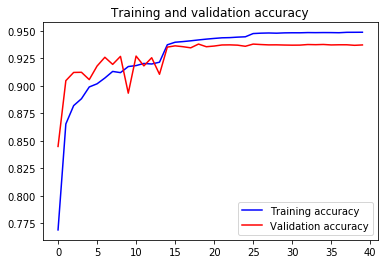

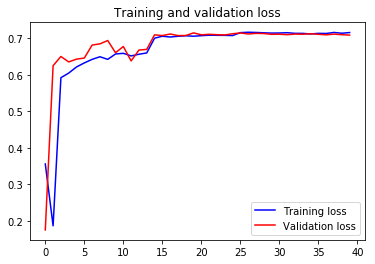

In [42]:
accuracy = hitory.history['my_iou_metric']
val_accuracy = history.history['val_my_iou_metric']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [45]:
model = load_model('model_current_best_TGS_v3.h5', custom_objects={'my_iou_metric': my_iou_metric})
model.load_weights('weights_current_best_TGS_v3.h5')

In [46]:
y_pred_train = np.round(model.predict({'img': x_train, 'feat': X_feat_img}, verbose=0, batch_size=8))

In [47]:
TP = 0
FP = 0
FN = 0
for i in range(y_pred_train.shape[0]):
    for j in range(y_pred_train.shape[1]):
        for k in range(y_pred_train.shape[2]):
            if (Y_train[i,j,k,0] == y_pred_train[i,j,k,0]):
                TP = TP + 1
            elif ((Y_train[i,j,k,0] != y_pred_train[i,j,k,0]) & (y_pred_train[i,j,k,0] == 1)):
                FP = FP + 1
            elif ((Y_train[i,j,k,0] != y_pred_train[i,j,k,0]) & (y_pred_train[i,j,k,0] == 0)):
                FN = FN + 1
    
iou_val = TP / (TP + FP + FN)
print('Val iou:', iou_val) 
print('TP {} - FP {} - FN {}'.format(TP,FP,FN)) 

Val iou: 0.9231581729343118
TP 67530286 - FP 2750447 - FN 2870638


In [51]:
outputs = model.layers[-1].output

model= Model(inputs=[inputs, input_features], outputs=[outputs])

c = optimizers.adam(lr = 0.01)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 101, 101, 1)  0                                            
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 101, 101, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_46 (BatchNo (None, 101, 101, 16) 64          conv2d_47[0][0]                  
__________________________________________________________________________________________________
activation_47 (Activation)      (None, 101, 101, 16) 0           batch_normalization_46[0][0]     
__________________________________________________________________________________________________
conv2d_48 

__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 6, 6, 256)    295168      dropout_12[0][0]                 
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 6, 6, 256)    1024        conv2d_67[0][0]                  
__________________________________________________________________________________________________
activation_67 (Activation)      (None, 6, 6, 256)    0           batch_normalization_66[0][0]     
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 6, 6, 256)    590080      activation_67[0][0]              
__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, 6, 6, 256)    1024        conv2d_68[0][0]                  
__________

activation_85 (Activation)      (None, 50, 50, 32)   0           batch_normalization_84[0][0]     
__________________________________________________________________________________________________
conv2d_86 (Conv2D)              (None, 50, 50, 32)   9248        activation_85[0][0]              
__________________________________________________________________________________________________
add_34 (Add)                    (None, 50, 50, 32)   0           conv2d_86[0][0]                  
                                                                 add_33[0][0]                     
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 50, 50, 32)   128         add_34[0][0]                     
__________________________________________________________________________________________________
activation_86 (Activation)      (None, 50, 50, 32)   0           batch_normalization_85[0][0]     
__________

In [55]:
model.load_weights('weights_current_best_TGS_v3.h5')

In [ ]:
model_checkpoint = ModelCheckpoint('model_current_best_TGS_v4.h5',monitor='my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 50
batch_size = 32
history = model.fit({'img': x_train, 'feat': X_feat_img}, y_train,
                    validation_split=0.15, 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint,reduce_lr], 
                    verbose=1)

Train on 6095 samples, validate on 1076 samples
Epoch 1/50
 160/6095 [..............................] - ETA: 37:48 - loss: 0.9316 - my_iou_metric_2: 0.16 - ETA: 37:39 - loss: 0.9276 - my_iou_metric_2: 0.16 - ETA: 37:27 - loss: 0.9022 - my_iou_metric_2: 0.15 - ETA: 37:46 - loss: 0.8953 - my_iou_metric_2: 0.15 - ETA: 37:52 - loss: 0.8793 - my_iou_metric_2: 0.1600

In [89]:
model = load_model('model_current_best_TGS_v4.h5', custom_objects={'my_iou_metric_2': my_iou_metric_2, 'lovasz_loss': lovasz_loss})
model.save_weights('weights_current_best_TGS_v4.h5')

In [ ]:
accuracy = history.history['my_iou_metric_2']
val_accuracy = history.history['val_my_iou_metric_2']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
model = load_model('model_current_best_TGS_v4.h5', custom_objects={'my_iou_metric_2': my_iou_metric_2, 'lovasz_loss': lovasz_loss})
model.load_weights('weights_current_best_TGS_v4.h5')

In [ ]:
y_pred_train = np.round(model.predict({'img': X_train, 'feat': X_feat_img}, verbose=0, batch_size=32))

In [ ]:
TP = 0
FP = 0
FN = 0
for i in range(y_pred_train.shape[0]):
    for j in range(y_pred_train.shape[1]):
        for k in range(y_pred_train.shape[2]):
            if (Y_train[i,j,k,0] == y_pred_train[i,j,k,0]):
                TP = TP + 1
            elif ((Y_train[i,j,k,0] != y_pred_train[i,j,k,0]) & (y_pred_train[i,j,k,0] == 1)):
                FP = FP + 1
            elif ((Y_train[i,j,k,0] != y_pred_train[i,j,k,0]) & (y_pred_train[i,j,k,0] == 0)):
                FN = FN + 1
    
iou_val = TP / (TP + FP + FN)
print('Val iou:', iou_val) 
print('TP {} - FP {} - FN {}'.format(TP,FP,FN)) 

In [ ]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    img = load_img(path + 'test/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

In [ ]:
len(X_test)

In [ ]:
X_test = X_test / 255

In [ ]:
id_test = []
for i in range(len(test_ids)):
    id_test = id_test + [(test_ids[i].split(".")[0])]
    
id_test[0:5]

In [ ]:
#test_cluster_one = to_categorical(test_cluster, num_classes=None)

In [75]:
data_test = pd.DataFrame(id_test,columns=["id"])
data_test["nombre"] = test_ids
data_test["cluster"] = test_cluster
#data_test["cluster_1"] = test_cluster_one[:,1]
#data_test["cluster_2"] = test_cluster_one[:,2]
#data_test["cluster_3"] = test_cluster_one[:,3]
#data_test["cluster_4"] = test_cluster_one[:,4]
#data_test["cluster_5"] = test_cluster_one[:,5]
#data_test["cluster_6"] = test_cluster_one[:,6]

In [76]:
data_test_final = data_test.join(df_depths.set_index('id'), on='id', how='left')

In [77]:
data_test_final.head()

,id,nombre,cluster,z
0,0005bb9630,0005bb9630.png,1,88
1,000a68e46c,000a68e46c.png,3,160
2,000c8dfb2a,000c8dfb2a.png,4,436
3,000d0a5f6c,000d0a5f6c.png,5,838
4,001ef8fc87,001ef8fc87.png,5,688


In [78]:
X_feat_test =  data_test_final.iloc[0:,3:4]

In [79]:
scaler = StandardScaler().fit(X_feat_test)
X_feat_test = scaler.transform(X_feat_test)

In [80]:
model = load_model('model_current_best_TGS_binary_v1.h5')
model.load_weights('weights_current_best_TGS_binary_v1.h5')

In [81]:
Y_test_pred = np.round(model.predict({'img': X_test, 'feat': X_feat_test}))

In [82]:
data_test_final["y_pred"] = Y_test_pred

In [83]:
data_test_final.head()

,id,nombre,cluster,z,y_pred
0,0005bb9630,0005bb9630.png,1,88,0.0
1,000a68e46c,000a68e46c.png,3,160,0.0
2,000c8dfb2a,000c8dfb2a.png,4,436,1.0
3,000d0a5f6c,000d0a5f6c.png,5,838,0.0
4,001ef8fc87,001ef8fc87.png,5,688,1.0


In [84]:
X_feat_img_test =  data_test_final.iloc[0:,2:5]

In [85]:
scaler = StandardScaler().fit(X_feat_img_test)
X_feat_img_test = scaler.transform(X_feat_img_test)

In [86]:
model = load_model('model_current_best_TGS_v4.h5', custom_objects={'my_iou_metric_2': my_iou_metric_2,'huber_loss': huber_loss})
model.load_weights('weights_current_best_TGS_v4.h5')

In [87]:
# Predict on train, val and test

preds_train = model.predict({'img': X_train, 'feat': X_feat_img}, verbose=0, batch_size=32)
preds_test  = model.predict({'img': X_test, 'feat': X_feat_img_test}, verbose=0, batch_size=32)

# Threshold predictions
preds_train_t = (preds_train > 0.65).astype(np.uint8)
preds_test_t = (preds_test > 0.65).astype(np.uint8)

In [88]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [89]:
preds_test_upsampled[0].shape

(101, 101)

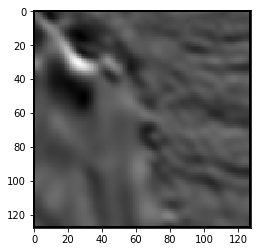

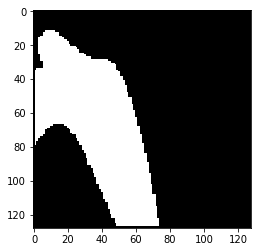

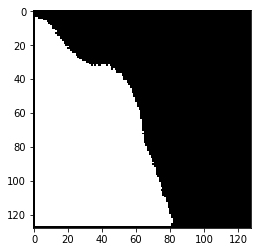

In [102]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [91]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [92]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('D:/MBIT-2017-18-Master-Deep-Learning/Reto TGS Kaggle - imágenes con sal/resultados/submission.csv')